Make a simple model for object detection, train it, and test it.  

- Model  
  - CNN several layers + fc
- Dataset
  - Made from MSCOCO dataset

In [1]:
from TKM.OD import modeling
import torch
from torch.utils.data import DataLoader

### DATASET

In [2]:
# datasets.yaml loaded
import yaml,json
with open("datasets.yaml","r") as f:
    datasets_cfg = yaml.safe_load(f)

# mscoco.one_person dataset
one_person_datasets_cfg = datasets_cfg['mscoco']['one_person']
json_path = one_person_datasets_cfg['annotation']
img_dir = one_person_datasets_cfg['image_dir']


In [3]:
# dataset[i]['image'] = np.array([]) 3rd order tensor
# dataset[i]['bbox'] = (x,y,w,h)
IMAGE_SIZE=(32,32)
RESIZE=True

from pycocotools.coco import COCO
import os
import cv2
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

coco = COCO(json_path)

with open(json_path,"r") as f:
    anns = json.load(f)

image_ids = [image['id'] for image in anns['images']]
dataset = list()
# i,image_ids, anns['images'] is in the same order
for i,id in tqdm(enumerate(image_ids)):
    data = dict()
    
    # dataset['image']
    file_name = anns['images'][i]['file_name']
    file_path = os.path.join(img_dir,file_name)
    image = Image.open(file_path)
    if RESIZE:
        original_image_size = image.size
        image = image.resize(IMAGE_SIZE)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0,0,0],[1,1,1])
    ])
    # Some images are gray scale
    if image.mode == 'L':
        image = image.convert("RGB")
    image = transform(image)
    
    data['image'] = image #torch.tensor(image,dtype=torch.float).transpose(0,2).transpose(1,2)

    # dataset['bbox']
    AnnIds = coco.getAnnIds(id,catIds=1)
    data['bbox'] = torch.tensor(coco.loadAnns(AnnIds)[0]['bbox'],dtype=torch.float)
    if RESIZE:
        data['bbox'][0] = data['bbox'][0] * IMAGE_SIZE[1] / original_image_size[1] # なぜかx,y が逆、、、
        data['bbox'][1] = data['bbox'][1] * IMAGE_SIZE[0] / original_image_size[0]
        data['bbox'][2] = data['bbox'][2] * IMAGE_SIZE[1] / original_image_size[1]
        data['bbox'][3] = data['bbox'][3] * IMAGE_SIZE[0] / original_image_size[0]
    dataset.append(data)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1079it [00:09, 108.18it/s]


In [4]:
# check data['image','bbox']
CHECK_DATA=False

if CHECK_DATA:
    import numpy as np
    import matplotlib.pyplot as plt

    image_show = np.array(data['image'].transpose(0,1).transpose(0,2),dtype=int) # (M,N,3) format
    image_show = image_show[:,:,[2,1,0]] # RGB->BGR 
    plt.imshow(image_show)

    # show bbox
    x,y,w,h = data['bbox']
    plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y],color='black')

### Dataset split into train and test (8:2)

In [5]:
perm = torch.randperm(len(dataset))
train_num = int(len(dataset)*0.8)
train_dataset = torch.utils.data.Subset(dataset,indices=perm[:train_num])
test_dataset = torch.utils.data.Subset(dataset,indices=perm[train_num:])

### DataLoader

In [6]:
batch_size=4
train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### MODEL

In [7]:
model = modeling.SimpleObjectDetector()
x = torch.randn(4,3,32,32) # 3色 32*32画像 
model(x)

tensor([[15.7318, 15.7713, 15.3963, 15.4719],
        [16.2474, 15.6774, 15.3787, 15.4193],
        [15.8117, 15.2812, 15.6944, 15.2224],
        [16.3075, 14.9273, 15.7502, 15.6488]], grad_fn=<AddBackward0>)

In [8]:
# check model
import torchsummary
model.cuda()
torchsummary.summary(model,(3,32,32),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
              ReLU-2            [-1, 8, 32, 32]               0
         MaxPool2d-3            [-1, 8, 16, 16]               0
         ConvLayer-4            [-1, 8, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,168
              ReLU-6           [-1, 16, 16, 16]               0
         MaxPool2d-7             [-1, 16, 8, 8]               0
         ConvLayer-8             [-1, 16, 8, 8]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                 [-1, 1024]       1,049,600
             ReLU-12                 [-1, 1024]               0
           Linear-13                    [-1, 4]           4,100
Total params: 2,104,692
Trainable param

In [9]:
import torch.nn as nn
from TKM.OD import metrics
import sys

# return the trained model
def experiment(loss_index=0,epoch_num=10,model_initialize=False,model=None,show_progress=False):

    if model_initialize:
        model = modeling.SimpleObjectDetector()
        model.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

    from time import time

    criterion = nn.L1Loss()
    if torch.cuda.is_available():
        criterion.cuda()

    model.train()
    start = time()
    for epoch in range(1,epoch_num+1):
        sum_loss = 0
        sum_IoU = 0

        model.train()

        for data in train_loader:
            image = data['image']
            bbox = data['bbox']
            image = image.cuda()
            bbox = bbox.cuda()

            pred = model(image)
            # print(pred[0].tolist())

            loss = criterion(bbox,pred)
            model.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            sum_IoU += metrics.IoU(bbox,pred).sum()
        if show_progress:
            print("epoch: {}, mean_loss: {}, mean_IoU: {}, elapsed_time: {}".format(epoch, sum_loss/(len(train_loader)*batch_size),
                                                                    sum_IoU/(len(train_loader)*batch_size),
                                                                    time() - start  ))
        
        # test
        model.eval()
        for data in test_loader:
            image = data['image']
            bbox = data['bbox']
            image = image.cuda()
            bbox = bbox.cuda()

            pred = model(image)

            if loss_index==0:
                loss = criterion(bbox,pred)
            elif loss_index==1:
                loss = criterion(bbox,pred) + metrics.IoU(bbox,pred).sum()
            elif loss_index==2:
                loss = metrics.IoU(bbox,pred).sum()
            else:
                print("loss not implemented error")
                sys.exit(1)

            sum_loss += loss.item()
            sum_IoU += metrics.IoU(bbox,pred).sum()

        if show_progress:
            print("epoch: {}, mean_loss: {}, mean_IoU: {}, elapsed_time: {}".format(epoch, sum_loss/(len(train_loader)*batch_size),
                                                                    sum_IoU/(len(train_loader)*batch_size),
                                                                    time() - start  )) 
    return model      

### Training and test

epoch: 1, mean_loss: 2.251554520041854, mean_IoU: 0.11968478560447693, elapsed_time: 0.6046164035797119
epoch: 1, mean_loss: 2.9784326509193138, mean_IoU: 0.16459523141384125, elapsed_time: 0.6599738597869873
epoch: 2, mean_loss: 2.2453679790099463, mean_IoU: 0.11686863005161285, elapsed_time: 1.1037487983703613
epoch: 2, mean_loss: 2.822978652737759, mean_IoU: 0.12751835584640503, elapsed_time: 1.15863037109375
epoch: 3, mean_loss: 2.2816752785885774, mean_IoU: 0.11675060540437698, elapsed_time: 1.616135835647583
epoch: 3, mean_loss: 2.863394893981792, mean_IoU: 0.13593511283397675, elapsed_time: 1.685199499130249
epoch: 4, mean_loss: 2.203674647543165, mean_IoU: 0.11990750581026077, elapsed_time: 2.177931547164917
epoch: 4, mean_loss: 2.739669401888494, mean_IoU: 0.1423967033624649, elapsed_time: 2.2570741176605225
epoch: 5, mean_loss: 2.310928314372345, mean_IoU: 0.11113768070936203, elapsed_time: 2.7366013526916504
epoch: 5, mean_loss: 2.897476398834476, mean_IoU: 0.121161021292209

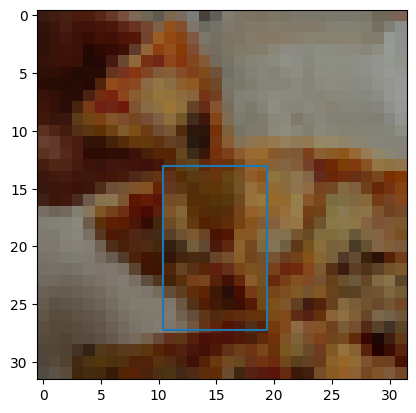

loss:11.693100929260254 
IoU:tensor([0.0768, 0.0000, 0.0521, 0.0128], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([10.4162, 13.0431,  8.9685, 14.2212], grad_fn=<ToCopyBackward0>)
tensor(0.0768, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 10.416156768798828 13.043069839477539 8.968467712402344 14.221186637878418


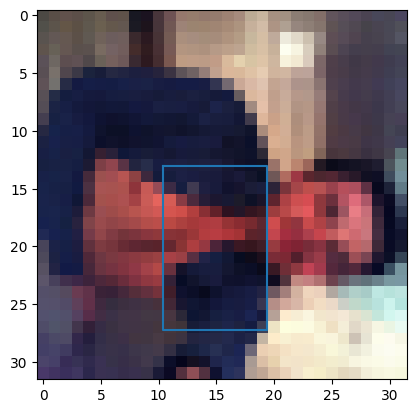

loss:8.949682235717773 
IoU:tensor([0.1354, 0.0872, 0.1251, 0.0509], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([10.4162, 13.0431,  8.9685, 14.2212], grad_fn=<ToCopyBackward0>)
tensor(0.1354, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 10.416156768798828 13.043069839477539 8.968467712402344 14.221186637878418


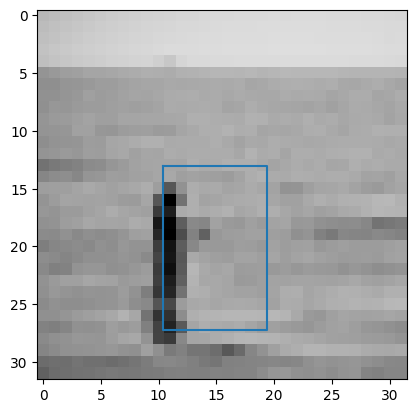

loss:9.727859497070312 
IoU:tensor([0.0836, 0.1451, 0.0000, 0.3354], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([10.4162, 13.0431,  8.9685, 14.2212], grad_fn=<ToCopyBackward0>)
tensor(0.0836, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 10.416156768798828 13.043069839477539 8.968467712402344 14.221186637878418


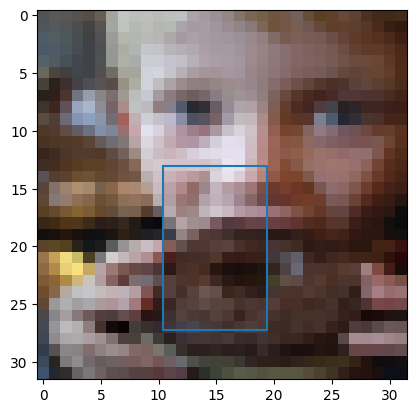

loss:7.358549118041992 
IoU:tensor([0.0000, 0.0000, 0.1070, 0.0000], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([10.4162, 13.0431,  8.9685, 14.2212], grad_fn=<ToCopyBackward0>)
tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 10.416156768798828 13.043069839477539 8.968467712402344 14.221186637878418


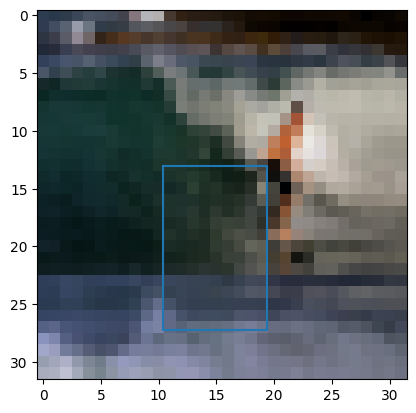

loss:11.213897705078125 
IoU:tensor([0.0950, 0.0000, 0.0594, 0.1178], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([10.4162, 13.0431,  8.9685, 14.2212], grad_fn=<ToCopyBackward0>)
tensor(0.0950, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 10.416156768798828 13.043069839477539 8.968467712402344 14.221186637878418


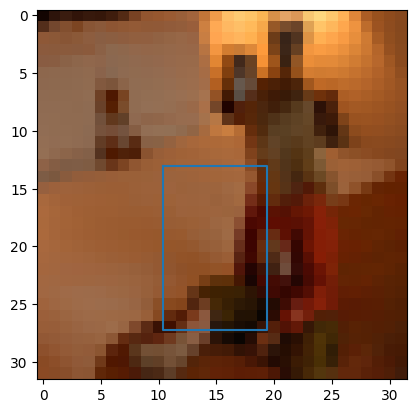

loss:8.005805015563965 
IoU:tensor([0.2046, 0.1342, 0.0000, 0.3706], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([10.4162, 13.0431,  8.9685, 14.2212], grad_fn=<ToCopyBackward0>)
tensor(0.2046, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 10.416156768798828 13.043069839477539 8.968467712402344 14.221186637878418


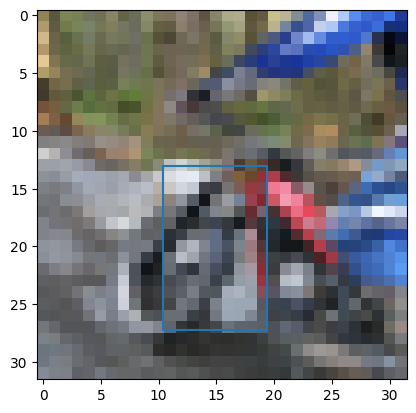

<Figure size 640x480 with 0 Axes>

In [17]:
# with training, check the prediction
model = experiment(loss_index=0,epoch_num=10,model_initialize=True,show_progress=True)

# show the model
criterion = nn.L1Loss()
model.eval()
for i,data in enumerate(test_loader):
    image = data['image']
    bbox = data['bbox']
    image = image.cuda()
    bbox = bbox.cuda()

    pred = model(image)

    loss = criterion(pred,bbox)
    IoU = metrics.IoU(pred,bbox)
    print(f"loss:{loss} \nIoU:{IoU}")
    

    # show the first ones of each batch
    import numpy as np
    import matplotlib.pyplot as plt

    number = 0 # 0~batch_size

    image_ = image[number]
    image_ = image_.cpu()
    image_show = np.array(image_.transpose(0,2).transpose(0,1)*255,dtype=int)

    plt.imshow(image_show)

    bbox = pred[number].cpu()
    print("predicted bbox:",bbox)
    x,y,w,h = bbox.tolist()
    plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y])
    print(IoU[number])
    print("predicted bbox:",x,y,w,h)
    plt.show()
    plt.clf()

    if i > 5:
        break

I can see all the predicted bbox is almost the same for all images.

#### Additional Study

loss:10.312408447265625 
IoU:tensor([0.0273, 0.0000, 0.0000, 0.0473], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.9526, 14.9191, 15.2653, 15.6790], grad_fn=<ToCopyBackward0>)
tensor(0.0273, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.952550888061523 14.919085502624512 15.265314102172852 15.679046630859375


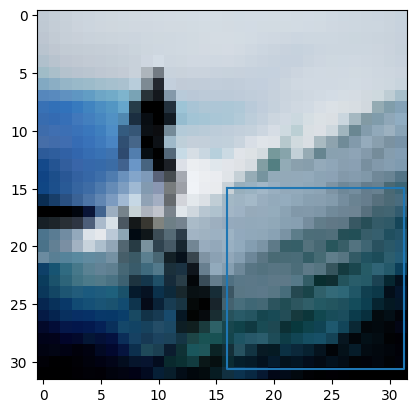

loss:5.4028215408325195 
IoU:tensor([0.1283, 0.2276, 0.0982, 0.0378], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([16.0728, 15.1257, 15.1651, 15.4016], grad_fn=<ToCopyBackward0>)
tensor(0.1283, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 16.072755813598633 15.125689506530762 15.165094375610352 15.401612281799316


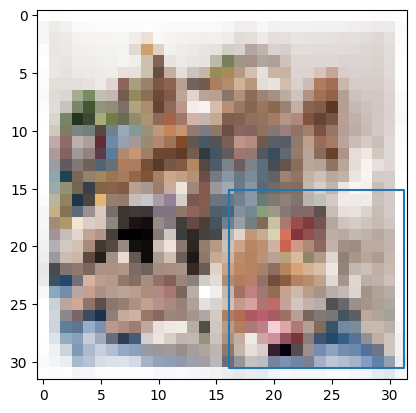

loss:9.536981582641602 
IoU:tensor([0.0556, 0.0096, 0.0938, 0.1575], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([16.0868, 15.3192, 15.0374, 15.4604], grad_fn=<ToCopyBackward0>)
tensor(0.0556, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 16.086763381958008 15.31916332244873 15.037412643432617 15.460384368896484


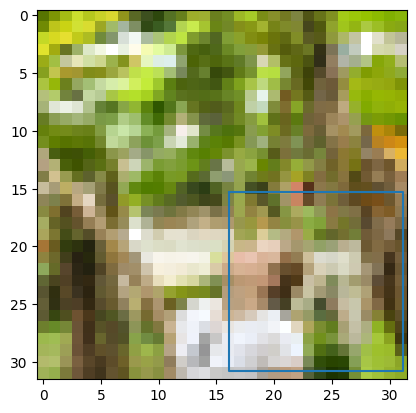

loss:8.403879165649414 
IoU:tensor([0.0251, 0.0835, 0.0798, 0.0814], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([16.1424, 15.1043, 15.4121, 15.6390], grad_fn=<ToCopyBackward0>)
tensor(0.0251, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 16.142385482788086 15.104329109191895 15.412092208862305 15.638965606689453


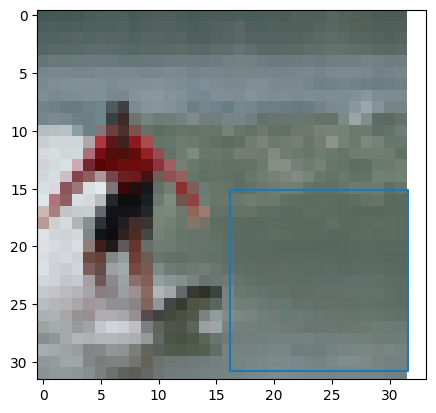

loss:5.544721603393555 
IoU:tensor([0.1193, 0.0238, 0.1702, 0.0949], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([16.0446, 14.9262, 15.2181, 15.6483], grad_fn=<ToCopyBackward0>)
tensor(0.1193, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 16.044586181640625 14.926156997680664 15.21808910369873 15.648305892944336


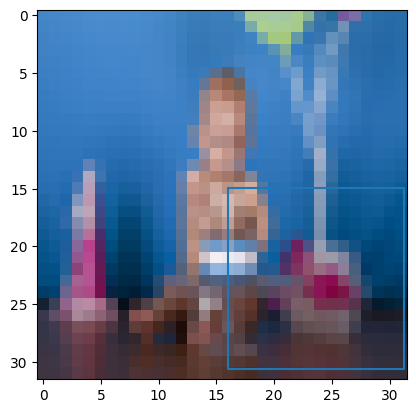

loss:6.356596946716309 
IoU:tensor([0.0000, 0.1620, 0.0539, 0.1155], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([16.1510, 15.2534, 15.4735, 15.5010], grad_fn=<ToCopyBackward0>)
tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 16.1510009765625 15.253355026245117 15.47350025177002 15.50100040435791


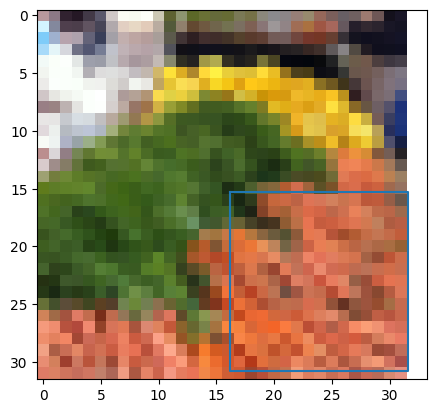

loss:8.822423934936523 
IoU:tensor([0.0816, 0.0000, 0.0792, 0.0563], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([16.1163, 15.0122, 15.5551, 15.5095], grad_fn=<ToCopyBackward0>)
tensor(0.0816, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 16.116252899169922 15.012195587158203 15.555051803588867 15.509526252746582


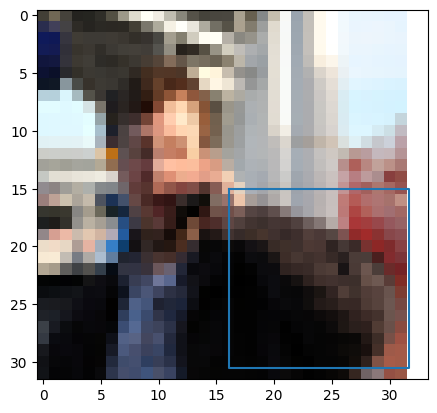

<Figure size 640x480 with 0 Axes>

In [18]:
# without training, check the prediction
model = experiment(loss_index=2,epoch_num=0,model_initialize=True,model=model)

# show the model
criterion = nn.L1Loss()
model.eval()
for i,data in enumerate(test_loader):
    image = data['image']
    bbox = data['bbox']
    image = image.cuda()
    bbox = bbox.cuda()

    pred = model(image)

    loss = criterion(pred,bbox)
    IoU = metrics.IoU(pred,bbox)
    print(f"loss:{loss} \nIoU:{IoU}")
    

    # show the first ones of each batch
    import numpy as np
    import matplotlib.pyplot as plt

    number = 0 # 0~batch_size

    image_ = image[number]
    image_ = image_.cpu()
    image_show = np.array(image_.transpose(0,2).transpose(0,1)*255,dtype=int)

    plt.imshow(image_show)

    bbox = pred[number].cpu()
    print("predicted bbox:",bbox)
    x,y,w,h = bbox.tolist()
    plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y])
    print(IoU[number])
    print("predicted bbox:",x,y,w,h)
    plt.show()
    plt.clf()

    if i > 5:
        break

I can see all the predicted bbox are almost the same even without training